In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.base import BaseEstimator
from scipy.spatial.distance import cdist
from sklearn.preprocessing import RobustScaler

In [5]:
df = pd.read_csv('creditcard.csv')

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<AxesSubplot:>

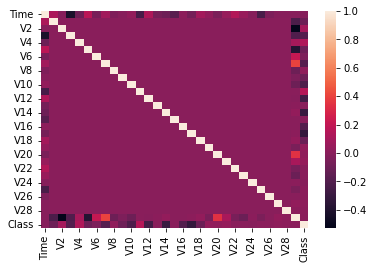

In [7]:
sns.heatmap(df.corr())

<AxesSubplot:xlabel='Time', ylabel='Count'>

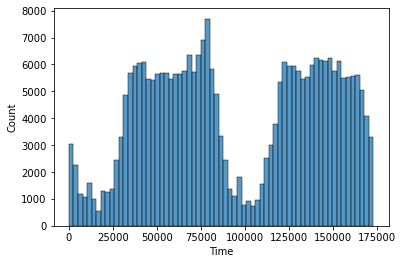

In [8]:
sns.histplot(df['Time'])

# Outlier std

In [54]:
def outlier_std(data, col, threshold=3):
    mean = data[col].mean()
    std = data[col].std()
    up_bound = mean + threshold * std
    low_bound = mean - threshold * std
    anomalies = pd.concat([data[col]>up_bound, data[col]<low_bound], axis=1).any(1)
    return anomalies, up_bound, low_bound

In [55]:
def get_column_outliers(data, columns=None, function=outlier_std, threshold=3):
    if columns:
        columns_to_check = columns
    else:
        columns_to_check = data.columns
        
    outliers = pd.Series(data=[False]*len(data), index=data_features.index, name='is_outlier')
    comparison_table = {}
    for column in columns_to_check:
        anomalies, upper_bound, lower_bound = function(data, column, threshold=threshold)
        comparison_table[column] = [upper_bound, lower_bound, sum(anomalies), 100*sum(anomalies)/len(anomalies)]
        outliers[anomalies[anomalies].index] = True
    
    comparison_table = pd.DataFrame(comparison_table).T
    comparison_table.columns=['upper_bound', 'lower_bound', 'anomalies_count', 'anomalies_percentage']
    comparison_table = comparison_table.sort_values(by='anomalies_percentage', ascending=False)
    
    return comparison_table, outliers

def anomalies_report(outliers):
    print("Total number of outliers: {}\nPercentage of outliers:   {:.2f}%".format(
            sum(outliers), 100*sum(outliers)/len(outliers)))    

In [33]:
data_features = df.iloc[:, :-1]
data_features.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [30]:
comparison_table, std_outliers = get_column_outliers(data_features, threshold=10)
anomalies_report(std_outliers)

Total number of outliers: 2104
Percentage of outliers:   0.74%


In [31]:
pd.merge(df, std_outliers.astype(int), left_index=True, right_index=True).head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,is_outlier
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0


In [47]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support


for i in range(1, 29):
    comparison_table, std_outliers = get_column_outliers(data_features, threshold=i)
    print(classification_report(df['Class'],std_outliers.astype(int)))
    print(i, "==="*20)

# Конечно же, нас будет интересовать precision. 
# Мы хотим понять, как много мошеннических сделок мы "окрашиваем" безопасными.
# Наибольший precision наблюдается, если мы считаем, что сделка считается мошеннической при 22 аномальных значениях

              precision    recall  f1-score   support

           0       1.00      0.01      0.01    284315
           1       0.00      1.00      0.00       492

    accuracy                           0.01    284807
   macro avg       0.50      0.50      0.01    284807
weighted avg       1.00      0.01      0.01    284807

1 ============================================================
              precision    recall  f1-score   support

           0       1.00      0.51      0.68    284315
           1       0.00      0.97      0.01       492

    accuracy                           0.51    284807
   macro avg       0.50      0.74      0.34    284807
weighted avg       1.00      0.51      0.68    284807

2 ============================================================
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    284315
           1       0.01      0.90      0.02       492

    accuracy                           0.87    284807
  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.21      0.11      0.15       492

    accuracy                           1.00    284807
   macro avg       0.61      0.56      0.57    284807
weighted avg       1.00      1.00      1.00    284807

22 ============================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.21      0.10      0.13       492

    accuracy                           1.00    284807
   macro avg       0.60      0.55      0.57    284807
weighted avg       1.00      1.00      1.00    284807

23 ============================================================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.20      0.08      0.11       492

    accuracy                           1.00    284807


# Distance Outliers

In [48]:
class DistanceOutliers(BaseEstimator):
    def __init__(self, metric='euclidean', percentile=90):
        self.metric = metric
        self.percentile = percentile
        
    def fit(self, X):
        self.centroid = np.mean(X, axis=0).values.reshape(-1, 1).T
        distances_train = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        self.threshold = np.percentile(distances_train, self.percentile)
        
    def predict(self, X):
        distances = cdist(self.centroid, X, metric=self.metric).reshape(-1)
        predictions = (distances > self.threshold).astype(int)
        return predictions

In [49]:
euclidian_model = DistanceOutliers(metric='euclidean', percentile=90)
euclidian_model.fit(df)
euclidian_outliers = euclidian_model.predict(df)
anomalies_report(euclidian_outliers)

Total number of outliers: 28481
Percentage of outliers:   10.00%


In [51]:
print(classification_report(df['Class'],euclidian_outliers.astype(int)))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    284315
           1       0.00      0.15      0.00       492

    accuracy                           0.90    284807
   macro avg       0.50      0.52      0.48    284807
weighted avg       1.00      0.90      0.95    284807



In [ ]:
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

eps = 0.05
eps_history = [eps]
while outlier_percentage>0.1:    
    model = DBSCAN(eps=eps).fit(df)
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 0.05
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)
    
model = DBSCAN(eps)
model.fit(df)
density_outlier = np.array([1 if label == -1 else 0 for label in model.labels_])